In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors, AllChem

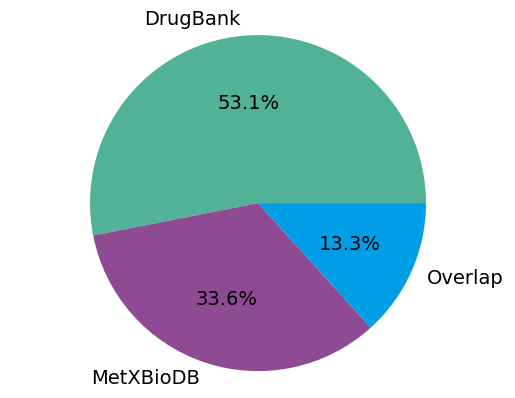

In [ ]:
def source_analysis(csv_file, save_figure=None):

    plt.rcParams.update({'font.size': 14, 'font.family': 'sans-serif'})

    df = pd.read_csv(csv_file)

    counts = df['source'].value_counts()

    labels = ['DrugBank', 'MetXBioDB', 'Overlap']

    colors = ['#52B297', '#8E4A93', '#009EE7', '#EF766E']
    # colors = ['lightblue', 'orchid', 'mediumseagreen', 'orange']
    plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=colors) #startangle=90)
    plt.axis('equal')

    if save_figure is not None:
        os.makedirs('figures', exist_ok=True)
        plt.savefig(f'figures/{save_figure}.eps', format='eps')

    plt.show()

after = '/projects/cc/se_users/larsson_kbvs588/test/MasterThesis/dataset/curated_data/combined_smiles_clean.csv'
source_analysis(after,'piechart')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


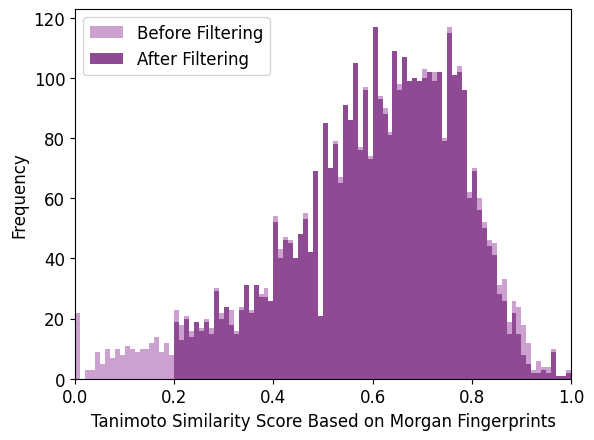

In [13]:
def fingerprint_similarity(csv_file):
    df = pd.read_csv(csv_file)
    parent_smiles = df['parent_smiles'].tolist()
    metabolite_smiles = df['child_smiles'].tolist()

    parent_mol = [Chem.MolFromSmiles(x) for x in parent_smiles]
    metabolite_mol = [Chem.MolFromSmiles(x) for x in metabolite_smiles]

    # parent_fps = [Chem.RDKFingerprint(x) for x in parent_mol]
    # metabolite_fps = [Chem.RDKFingerprint(x) for x in metabolite_mol]
    parent_fps = [AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=1024) for x in parent_mol]
    metabolite_fps = [AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=1024) for x in metabolite_mol]

    fingerprint_similarities = []
    for i in range(len(parent_smiles)):
        s = DataStructs.TanimotoSimilarity(parent_fps[i], metabolite_fps[i]) 
        fingerprint_similarities.append(s)

    return fingerprint_similarities  


def plot_fingerprint_similarity(csv_file_before, csv_file_after, save_figure=None):

    plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})

    similarity_before = fingerprint_similarity(csv_file_before)
    similarity_after = fingerprint_similarity(csv_file_after)

    x_range = (0, 1)
    bin_width = 0.01
    bins = np.arange(x_range[0], x_range[1] + bin_width, bin_width)

    plt.hist(similarity_before, bins=bins, color='#CCA0CF',label='Before Filtering')
    plt.hist(similarity_after, bins=bins, color='#8E4A93',label='After Filtering')
    plt.xlabel('Tanimoto Similarity Score Based on Morgan Fingerprints')
    plt.ylabel('Frequency')
    plt.legend()
    # plt.ylim(0, 120)
    plt.xlim(0, 1)

    if save_figure is not None:
        os.makedirs('figures', exist_ok=True)
        plt.savefig(f'figures/{save_figure}.eps', format='eps')

    plt.show()

before = '/projects/cc/se_users/larsson_kbvs588/test/MasterThesis/dataset/curated_data/combined_smiles_before_filters.csv'
after = '/projects/cc/se_users/larsson_kbvs588/test/MasterThesis/dataset/curated_data/combined_smiles_clean.csv'
plot_fingerprint_similarity(before, after, 'fingerprints')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


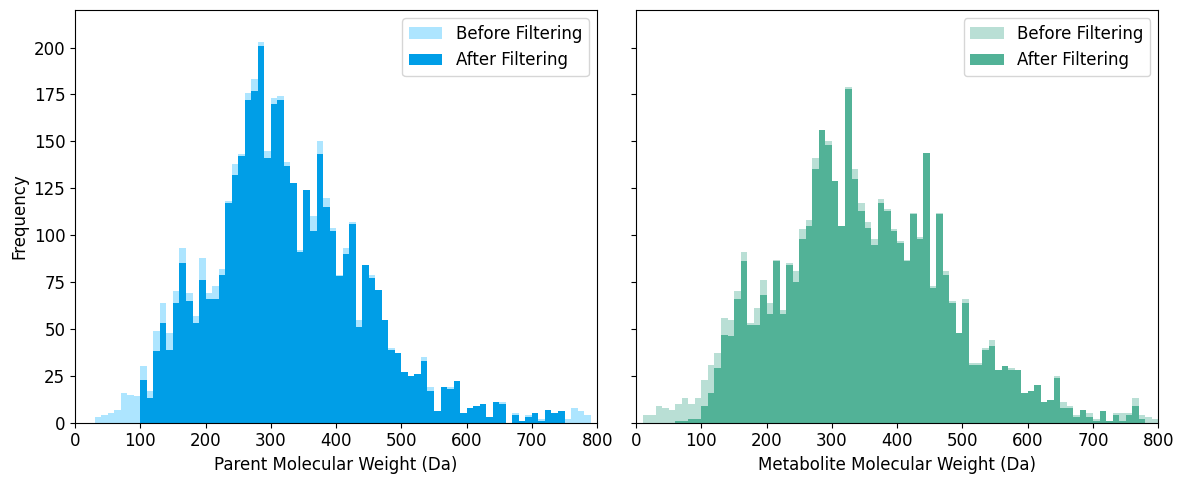

In [26]:
def molecular_weight_analysis_2(dataset):

    metabolite_weights, parent_weights = [], []

    parents = dataset["parent_smiles"]
    metabolites = dataset["child_smiles"]

    for parent, metabolite in zip(parents, metabolites):

        metabolite_weight = Descriptors.ExactMolWt(Chem.MolFromSmiles(metabolite))
        metabolite_weights.append(metabolite_weight)

        parent_weight = Descriptors.ExactMolWt(Chem.MolFromSmiles(parent))
        parent_weights.append(parent_weight)

    return metabolite_weights, parent_weights

def plot_molecular_weights_comparison(before_file, after_file, save_figure = None):

    df_before = pd.read_csv(before_file)
    df_after = pd.read_csv(after_file)

    metabolite_weights_before, parent_weights_before = molecular_weight_analysis_2(df_before)
    metabolite_weights_after, parent_weights_after = molecular_weight_analysis_2(df_after)

    plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    x_range = (0, 800)
    bin_width = 10
    bins = np.arange(x_range[0], x_range[1] + bin_width, bin_width)

    axes[0].hist(parent_weights_before, bins=bins, color='#ADE5FF', label='Before Filtering')
    axes[0].hist(parent_weights_after, bins=bins, color='#009EE7', label='After Filtering')
    axes[0].set_xlabel('Parent Molecular Weight (Da)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_xlim(0, 800)
    axes[0].legend()

    axes[1].hist(metabolite_weights_before, bins=bins, color='#B9DFD5', label='Before Filtering')
    axes[1].hist(metabolite_weights_after, bins=bins, color='#52B297', label='After Filtering')
    axes[1].set_xlabel('Metabolite Molecular Weight (Da)')
    axes[1].set_xlim(0, 800)
    axes[1].set_ylim(0, 220)
    axes[1].legend()

    if save_figure is not None:
        os.makedirs('figures', exist_ok=True)
        plt.savefig(f'figures/{save_figure}.eps', format='eps')

    plt.tight_layout()
    plt.show()

before = '/projects/cc/se_users/carlsson_ksmq649/MasterThesis/dataset/curated_data/combined_smiles_before_filters.csv'
after = '/projects/cc/se_users/carlsson_ksmq649/MasterThesis/dataset/curated_data/combined_smiles_clean.csv'
plot_molecular_weights_comparison(before, after, save_figure='weight_comparison')

In [18]:
# Element count
def define_atoms(molecule):
    mol = Chem.MolFromSmiles(molecule)
    atoms = [atom.GetSymbol() for atom in mol.GetAtoms()]
    atom_counts = Counter(atoms)
    return atom_counts

def analyse_atoms(data, column):
    total_atoms_count = Counter()
    
    for molecule in data[column]:
        atom_counts = define_atoms(molecule)
        total_atoms_count.update(atom_counts)
    
    return total_atoms_count

def print_atom_counts(atom_counts):
    for atom, count in atom_counts.items():
        print(f"{atom}: {count}")


# name = 'drugbank' # [ 'drugbank' 'metxbiodb' ]
# dataset = f'/projects/cc/se_users/larsson_kbvs588/test/MasterThesis/dataset/curated_data/{name}_smiles.csv'

after = '/projects/cc/se_users/carlsson_ksmq649/MasterThesis/dataset/curated_data/combined_smiles_before_filters.csv'
data = pd.read_csv(after)

parents_count = analyse_atoms(data, 'parent_smiles')
children_count = analyse_atoms(data, 'child_smiles')

print("Parent SMILES element counts:")
print_atom_counts(parents_count)

print("\nChild SMILES element counts:")
print_atom_counts(children_count)

Parent SMILES element counts:
C: 76761
N: 8813
O: 13628
P: 138
Co: 1
I: 51
F: 1020
Cl: 1051
S: 762
As: 5
Bi: 1
B: 11
Br: 97
Pt: 9
Se: 8
Fe: 1

Child SMILES element counts:
C: 76760
N: 8425
O: 19828
P: 189
Co: 1
I: 37
F: 913
Cl: 951
S: 964
As: 4
Bi: 1
Fe: 2
Br: 84
Pt: 9
Se: 8


In [21]:
def number_of_children(csv):
    df = pd.read_csv(csv)
    child_counts = df['parent_smiles'].value_counts()
    occurrence_summary = child_counts.value_counts().sort_index()

    print("Number of children summary:")
    for number_of_children, frequency in occurrence_summary.items():
        print(f"{frequency} parents with {number_of_children} child(ren)")

after = '/projects/cc/se_users/carlsson_ksmq649/MasterThesis/dataset/curated_data/combined_smiles_clean.csv'
number_of_children(after)

Number of children summary:
1324 parents with 1 child(ren)
494 parents with 2 child(ren)
228 parents with 3 child(ren)
95 parents with 4 child(ren)
46 parents with 5 child(ren)
26 parents with 6 child(ren)
17 parents with 7 child(ren)
9 parents with 8 child(ren)
3 parents with 9 child(ren)
1 parents with 10 child(ren)
3 parents with 11 child(ren)
1 parents with 13 child(ren)
1 parents with 19 child(ren)
